# Peru, VT Snowpack Data

In [4]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
import copy
import math as m
from scipy import stats
import statsmodels.api as sm

Load functions for analysis

In [5]:
%run /Users/paulnicknish/Desktop/newEnglandSnowpack/research/analysisFunctions.ipynb

In [6]:
# Station Data

dataPath = '/Users/paulnicknish/Desktop/NewEnglandSnowpack/research/peruVT/1940Through2024.csv'
# Read in the data
data = pd.read_csv(dataPath)

dates = data.DATE.to_numpy()
snowDepth = data.SNWD.to_numpy()

In [7]:
# Find the indices in the data corresponding to each year
    # we want to track winter seasons, thus the year will be defined from Sept to Sept

lastYearInClim = 2024
startingYear = 1941

yearRange = np.arange(startingYear,lastYearInClim+1)

indicesByYear = findYearIndices(startingYear,lastYearInClim,dates)

In [8]:
# Select the snow depth in each year

snowDepthByYears = []
datesByWinter = []

for iyear in indicesByYear:
    snowDepthInYear = snowDepth[iyear]
    snowDepthByYears = snowDepthByYears + [snowDepthInYear]

    datesByWinter = datesByWinter + [dates[iyear]]

# Turn calendar date into day of year (with Sept 1 = day 1)
for iy in range(len(datesByWinter)):
    for iday in range(len(datesByWinter[iy])):

        datesByWinter[iy][iday] = dayOfYearAccountingForLeapYear(datesByWinter[iy][iday])+122

        if datesByWinter[iy][iday]>366 and datesByWinter[iy][iday] != datesByWinter[iy][-1]:
            datesByWinter[iy][iday] = datesByWinter[iy][iday]-366

        # if datesByWinter[iy][-1]==365: # March 1 is always the 61st day of the year, Feb 29 is day 60 in leap years
        #     datesByWinter[iy][datesByWinter[iy]>=60+121] = datesByWinter[iy][datesByWinter[iy]>=60+121] + 1

In [9]:
## For Peru, VT Only ##

# remove bad data

for i in snowDepthByYears:
    i[i>100] = np.nan

In [10]:
# Calculate the average over the years


dayAverageSnowDepth = []
for day in range(1,367):
    runningListForMean = []
    for iy in range(len(datesByWinter)):
        if day in datesByWinter[iy]:
            # Find the index of that day in datesByWinter[iy]
            indexOfParticularDay = np.nonzero(datesByWinter[iy] == day)[0][0]
            runningListForMean = runningListForMean + [snowDepthByYears[iy][indexOfParticularDay]]
    dayAverageSnowDepth = dayAverageSnowDepth + [np.nanmean(np.array(runningListForMean))]


Text(0.5, 1.0, 'Peru, VT Snowpack')

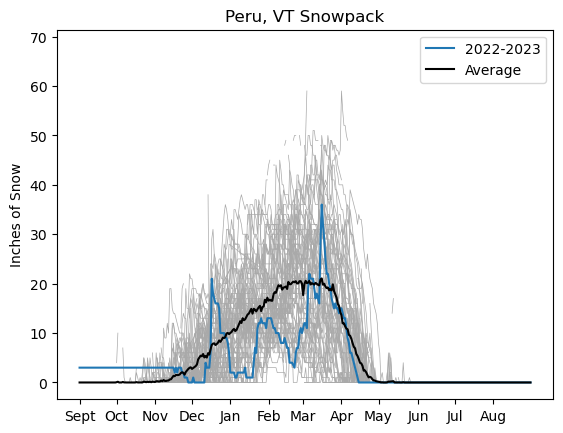

In [11]:
### Highlight a particular year (give the year in the spring of the winter season) ###
#yearHighlight = input('Enter year')
yearHighlight = 2023

# Put all of these years on a plot
for i in range(len(snowDepthByYears)):
    plt.plot(datesByWinter[i],snowDepthByYears[i],c='darkgray',linewidth = .5)

# Plot highlighted year
indOfHigherYear = np.nonzero(yearRange == yearHighlight)[0][0]
plt.plot(datesByWinter[indOfHigherYear],fillInNans(snowDepthByYears[indOfHigherYear]),label = '{}-{}'.format(yearHighlight-1,yearHighlight))

# Plot the average
plt.plot(range(1,367),dayAverageSnowDepth,label='Average',c='k')
plt.legend()

plt.xticks([dayOfYear('2000-09-01')+122-366, dayOfYear('2000-10-01')+122-366,
            dayOfYear('2000-11-01')+122-366, dayOfYear('2000-12-01')+122-366,
            dayOfYear('2001-01-01')+122, dayOfYear('2001-02-01')+122,
            dayOfYear('2001-03-01')+122, dayOfYear('2001-04-01')+122,
            dayOfYear('2001-05-01')+122, dayOfYear('2000-06-01')+122,
            dayOfYear('2000-07-01')+122, dayOfYear('2000-08-01')+122],
           ['Sept','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug']);

plt.ylabel('Inches of Snow')

plt.title('Peru, VT Snowpack')

# Look at Changes in variability using FFT

In [12]:
# First, replace all the nans in the data using linear interpolation
snowDepthByYears_noNAN = [fillInNans(year) for year in snowDepthByYears]

In [13]:
# Calculate the amplitudes of the Fourier Components for each year
snowDepthByYearsAmps = [ampFromFFT(year)[0] for year in snowDepthByYears_noNAN]

In [14]:
# Calculate the total harmonic distortion of each year
snowDepthByYearsTHD = np.array([THD(year) for year in snowDepthByYearsAmps])

Text(0.5, 0, 'Year')

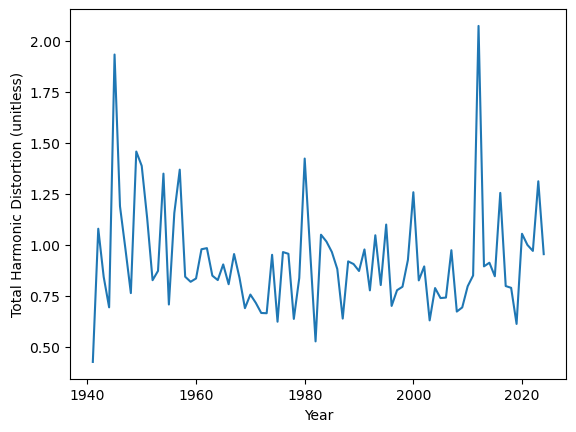

In [15]:
yearRange = yearRange
plt.plot(yearRange,snowDepthByYearsTHD)
plt.ylabel('Total Harmonic Distortion (unitless)')
plt.xlabel('Year')

0.2862643403820155


Text(0.5, 0, 'Year')

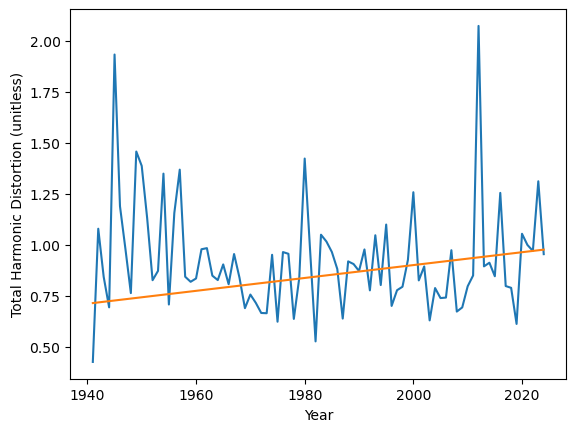

In [16]:
startYearForSlope = 1980
coeffs = np.polyfit(yearRange[yearRange>startYearForSlope],snowDepthByYearsTHD[yearRange>startYearForSlope],1)
plt.plot(yearRange,snowDepthByYearsTHD)
plt.plot(yearRange,yearRange*coeffs[0] + coeffs[1])

slope, intercept, r_value, p_value, std_err = stats.linregress(yearRange[yearRange>startYearForSlope],snowDepthByYearsTHD[yearRange>startYearForSlope])

print(p_value)
plt.ylabel('Total Harmonic Distortion (unitless)')
plt.xlabel('Year')

In [17]:

xxx = np.random.random(10)
yyy = np.random.random(10)
slope, intercept, r_value, p_value, std_err = stats.linregress(yearRange[yearRange>startYearForSlope],snowDepthByYearsTHD[yearRange>startYearForSlope])

confidence_interval = 2.58*std_err

In [18]:
p_value

0.2862643403820155

In [19]:
import numpy as np, statsmodels.api as sm

nsample = 100
x = np.linspace(0, 10, nsample)
X = np.column_stack((x, x**2))
beta = np.array([1, 0.1, 10])
e = np.random.normal(size=nsample)

X = sm.add_constant(X)
y = np.dot(X, beta) + e

mod = sm.OLS(yyy, xxx)
res = mod.fit()
print(res.conf_int(0.01))   # 99% confidence interval

[[0.12460308 0.97525755]]


In [20]:
slope-confidence_interval

-0.0043789462586626225

In [21]:
res

# Other things to look at

Text(0.5, 1.0, 'Peak Snowpack')

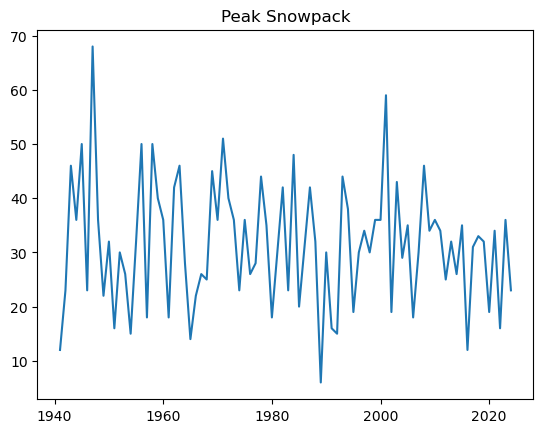

In [22]:
## Look at max snowpack overtime

maxSnowPackByWinter = [np.nanmax(winterSnow) for winterSnow in snowDepthByYears]
plt.plot(yearRange,maxSnowPackByWinter)
plt.title('Peak Snowpack')



Text(0.5, 1.0, 'Date of Max Snowpack')

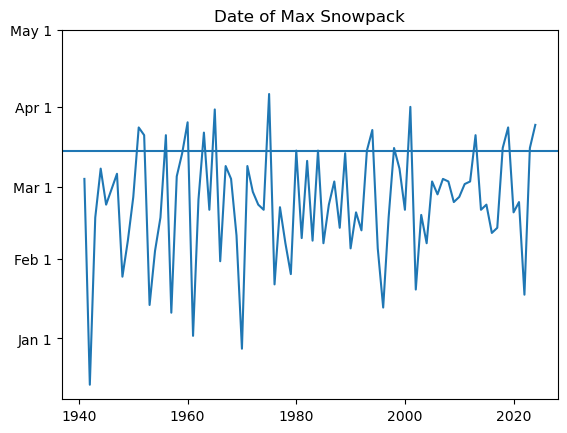

In [23]:
## Look at date of peak snowpack
dateOfPeak = [datesByWinter[i][np.nanargmax(snowDepthByYears[i])] for i in range(len(snowDepthByYears))]
plt.plot(yearRange,dateOfPeak)

dateOfPeakAvg = np.nanargmax(dayAverageSnowDepth)
plt.axhline(dateOfPeakAvg)

plt.yticks([dayOfYear('2001-01-01')+122, dayOfYear('2001-02-01')+122,
            dayOfYear('2001-03-01')+122, dayOfYear('2001-04-01')+122,
            dayOfYear('2001-05-01')+122],
           ['Jan 1','Feb 1','Mar 1','Apr 1','May 1']);

plt.title('Date of Max Snowpack')

Text(0.5, 0, 'Year')

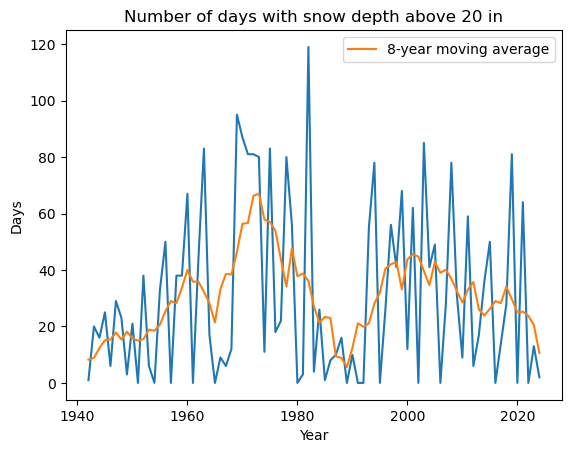

In [26]:
# number of days with snowpack above a given threshold (indicated by bcThresh)

bcThresh = 20


daysWithBCIn = [len(winterSnow[winterSnow>=bcThresh]) for winterSnow in snowDepthByYears]
plt.plot(yearRange[1:],daysWithBCIn[1:])

windowSize = 8
a = movingaverage(daysWithBCIn[1:],windowSize)
plt.plot(yearRange[1:],a,label='{}-year moving average'.format(windowSize))

plt.title('Number of days with snow depth above {} in'.format(bcThresh))

plt.legend()
plt.ylabel('Days')
plt.xlabel('Year')

# Scratch Work

In [427]:
# Amplitude Spectrum from FFT
sampleFrequency = 366 # samples per year
timeOverYear = np.arange(1,367)
freq = np.arange(0,sampleFrequency,sampleFrequency/len(timeOverYear))
N = len(dayAverageSnowDepth) # Number of samples

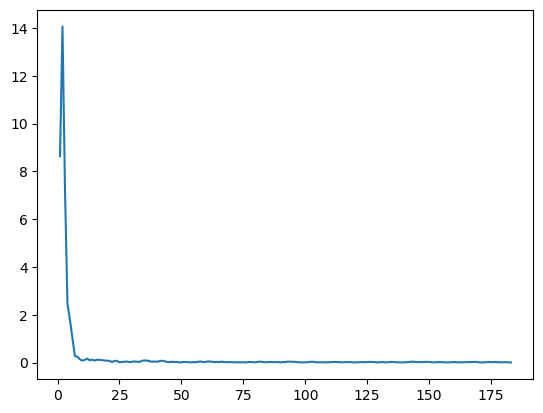

In [428]:
# Amplitude Spectrum from FFT
xk = abs(np.fft.fft(dayAverageSnowDepth))/N; # Two-sided amplitude
xk = xk[0:int(N/2)]; # One-sided
xk[1:-2] = 2*xk[1:-2]; # Double values except for DC and Nyquist

plt.plot(freq[1:int(N/2+1)],xk)

In [304]:
indOfHigherYear

86

In [435]:
testYear = snowDepthByYears[50]
np.nansum(testYear)/366

1.226775956284153

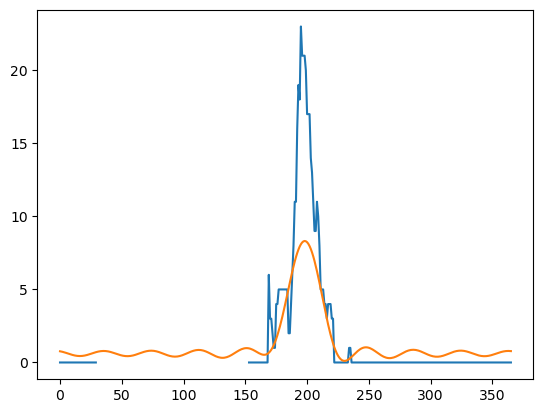

In [477]:
a = np.fft.fft(fillInNans(testYear))
b = np.fft.fft(fillInNans(testYear))
a[0] = 0
K = 180
b[10:] = 0


#plt.plot(np.fft.ifft(a))
plt.plot(testYear)
plt.plot(np.fft.ifft(b))

In [460]:
len(b)

366

In [ ]:
plt.plot(freq(1:N/2+1),xk, 'LineWidth', 3)
grid on
title("Amplitude Using FFT")
xlabel("Frequency (Hz)")
ylabel("Amplitude")

In [429]:
# Power Spectrum
Y=np.fft.fft(dayAverageSnowDepth);
N=2*m.floor(len(Y)/2); 
P=abs(Y[2:int(N/2+1)])
s=np.arange(1,N/2)/N


snowDepthByYears[indOfHigherYear]

Y2=np.fft.fft(snowDepthByYears[indOfHigherYear]);
N=2*m.floor(len(Y2)/2); 
P2=abs(Y2[2:int(N/2+1)])
s=np.arange(1,N/2)/N

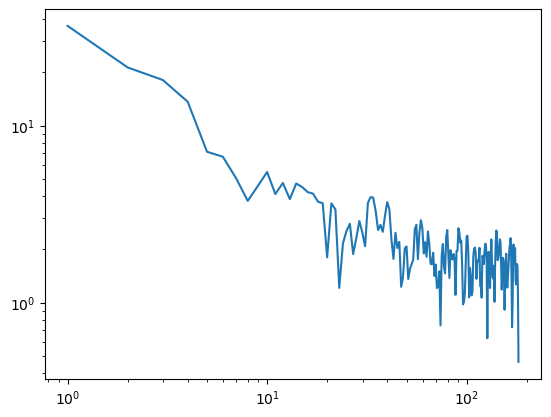

In [430]:
plt.loglog(s*365,np.sqrt(P))
plt.loglog(s*365,np.sqrt(P2))

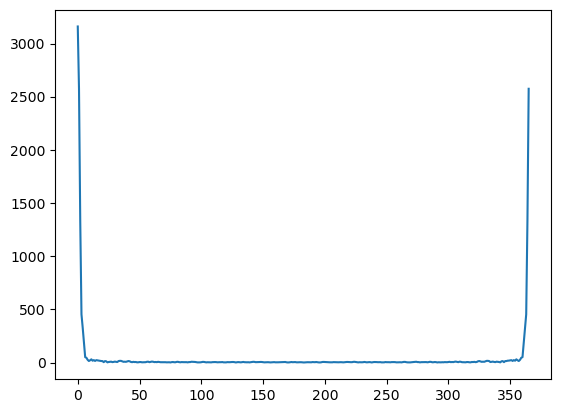

In [220]:
plt.plot(abs(Y))

In [185]:
N/2+1

184.0

In [303]:
for i in range(len(snowDepthByYears)):
    print(sum(np.isnan(snowDepthByYears[i])))

268
174
211
215
135
191
192
185
218
189
195
211
197
195
183
211
213
212
123
1
2
1
3
2
1
1
3
1
1
29
0
7
8
5
0
6
1
1
0
19
1
1
0
1
1
2
2
23
6
3
123
68
1
3
32
6
3
6
9
18
95
1
22
76
1
1
8
4
13
42
18
24
11
1
36
33
3
2
2
2
5
41
63
15
1
1
0
2
1
5
0
1
1
11


In [343]:
def fillInNans(yearlyTimeSeries):
    '''fft can only be used when no NANs are present in the data. Fill in missing values using linear interpolation.
    Note that this function sets snowpack to 0 before October 15 and after May 15. While this does 0-out some data,
    I don't think the impacts are significant.
    '''
    x  = yearlyTimeSeries
    x[dayOfYear('2001-05-15')+122-1:] = 0
    x[:dayOfYear('2000-10-01')+122-366-1] = 0
    xi = np.arange(len(x))

    mask = np.isfinite(x)
    xfiltered = np.interp(xi, xi[mask], x[mask])

    return xfiltered

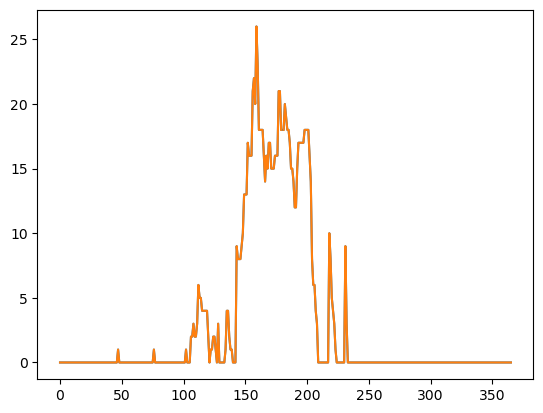

In [341]:
x  = snowDepthByYears[x]
x[dayOfYear('2001-05-15')+122-1:] = 0
x[:dayOfYear('2000-10-01')+122-366-1] = 0
xi = np.arange(len(x))

mask = np.isfinite(x)
xfiltered = np.interp(xi, xi[mask], x[mask])


plt.plot(xfiltered)
plt.plot(x)

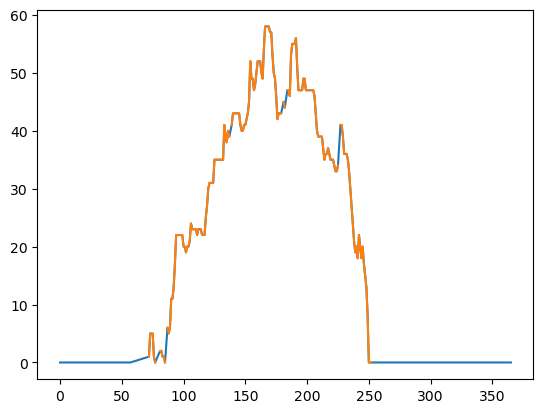

In [319]:
fillInNans(

In [314]:
xfiltered

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  1.,  1.,  1.,
        1.,  1.,  1.,  2.,  2.,  1.,  0.,  0.,  0., 13., 13., 13.,  8.,
        6.,  5.,  6.,  4.,  4.,  9., 10., 10., 10., 20., 20., 21., 21.,
       21., 21., 21., 21., 20., 20., 16., 16., 16., 16., 16.,  9.,  9.,
        9.,  9.,  8.,  8.,  8.,  8.,  9.,  9., 15., 13., 13., 13., 13.,
       13., 14., 14., 14., 14., 14., 14., 14., 15., 14., 12., 12., 12.,
       12., 12., 12., 12., 13., 12., 27., 27., 27., 24., 24., 24., 24.,
       23., 24., 23., 18., 22., 26., 28., 28., 28., 28., 28., 21., 21.,
       21., 21., 32., 33., 18., 22., 20., 20., 20., 20., 20., 20